BIDV

In [4]:
#. Import thư viện cần thiết
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [5]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/BID.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)


In [6]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,03/01/2024,53500.0,53300.0,54300.0,52400.0,1250000,0.0094
1,02/29/2024,53000.0,53900.0,54000.0,53000.0,1340000,-0.0167
2,02/28/2024,53900.0,53200.0,54800.0,52300.0,2340000,0.0170
3,02/27/2024,53000.0,53700.0,54000.0,53000.0,1740000,-0.0112
4,02/26/2024,53600.0,52800.0,54500.0,52000.0,1530000,0.0308
...,...,...,...,...,...,...,...
1247,03/07/2019,26710.5,26787.0,26978.3,26557.4,2140000,0.0043
1248,03/06/2019,26595.7,26480.9,26710.5,26327.8,2009999,0.0043
1249,03/05/2019,26480.9,25409.4,27016.6,25409.4,5300000,0.0298
1250,03/04/2019,25715.5,25332.9,25830.3,25256.3,1150000,0.0228


In [7]:
df1=df.reset_index()['Price']

In [8]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
#. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [10]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [12]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [13]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1075
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0156
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0067
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0050
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0037
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0029
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0020
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0016
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0014
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - lo

In [15]:
# . Dự báo dữ liệu test

y_pred=model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [16]:
# . Chuẩn hóa dữ liệu y_pred

y_pred=scaler.inverse_transform(y_pred)

In [17]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [18]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 595.7365122597333
Testing MAPE: 1.8133024832063507
Testing Mae: 481.6633861157717


In [19]:
# Dự báo 30 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.09704668]
101
1 day input [0.09667164 0.11675661 0.12931218 0.10797067 0.10294779 0.09918144
 0.09918144 0.06779416 0.07030725 0.07156051 0.04519611 0.05021899
 0.04896245 0.05524188 0.05524188 0.03766342 0.03641016 0.04394285
 0.02762094 0.03515362 0.04770919 0.03766342 0.05021899 0.04770919
 0.05147553 0.03515362 0.03515362 0.03766342 0.03891997 0.02259805
 0.02259805 0.03264054 0.02762094 0.02762094 0.01757517 0.02008825
 0.03515362 0.         0.02259805 0.03013074 0.03515362 0.04268631
 0.05021899 0.04770919 0.07030725 0.06528436 0.06151802 0.05272879
 0.03891997 0.05021899 0.05775168 0.04519611 0.05272879 0.03515362
 0.01255557 0.04394285 0.06277456 0.06277456 0.09039222 0.0979249
 0.10545759 0.0979249  0.10043798 0.09039222 0.09039222 0.10671413
 0.10545759 0.10545759 0.12303604 0.10420433 0.11424681 0.11550335
 0.12931218 0.12303604 0.11173701 0.11801316 0.12805892 0.10545759
 0.12303604 0.13056872 0.12554584 0.10797067 0.0929053  0.0979249
 0.11299027 0.10545759 0.13810141 0

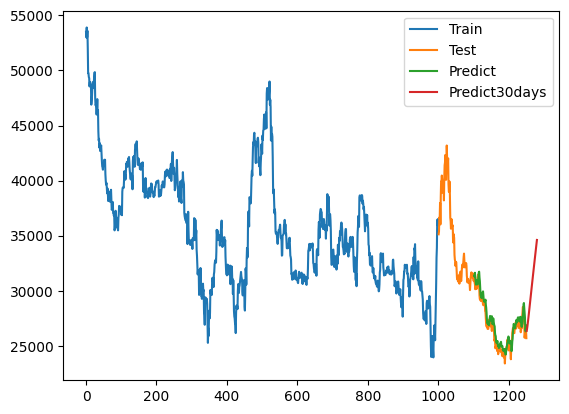

In [20]:
# 14.Vẽ hình du doan 30 ngay

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [21]:
# Dự báo 60 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1

[0.09704668]
101
1 day input [0.09667164 0.11675661 0.12931218 0.10797067 0.10294779 0.09918144
 0.09918144 0.06779416 0.07030725 0.07156051 0.04519611 0.05021899
 0.04896245 0.05524188 0.05524188 0.03766342 0.03641016 0.04394285
 0.02762094 0.03515362 0.04770919 0.03766342 0.05021899 0.04770919
 0.05147553 0.03515362 0.03515362 0.03766342 0.03891997 0.02259805
 0.02259805 0.03264054 0.02762094 0.02762094 0.01757517 0.02008825
 0.03515362 0.         0.02259805 0.03013074 0.03515362 0.04268631
 0.05021899 0.04770919 0.07030725 0.06528436 0.06151802 0.05272879
 0.03891997 0.05021899 0.05775168 0.04519611 0.05272879 0.03515362
 0.01255557 0.04394285 0.06277456 0.06277456 0.09039222 0.0979249
 0.10545759 0.0979249  0.10043798 0.09039222 0.09039222 0.10671413
 0.10545759 0.10545759 0.12303604 0.10420433 0.11424681 0.11550335
 0.12931218 0.12303604 0.11173701 0.11801316 0.12805892 0.10545759
 0.12303604 0.13056872 0.12554584 0.10797067 0.0929053  0.0979249
 0.11299027 0.10545759 0.13810141 0

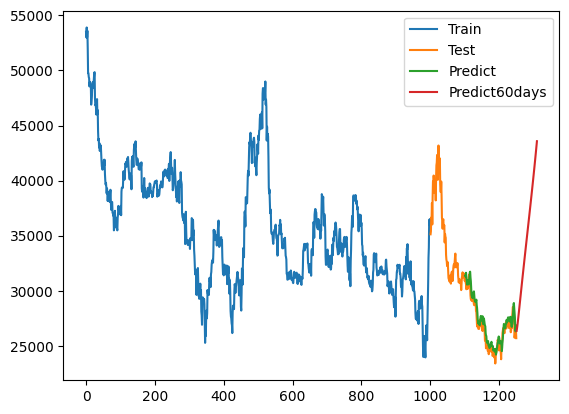

In [22]:
#Vẽ hình du doan 60 ngay

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index_60,scaler.inverse_transform(lst_output_60))

plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

In [23]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.09704668]
101
1 day input [0.09667164 0.11675661 0.12931218 0.10797067 0.10294779 0.09918144
 0.09918144 0.06779416 0.07030725 0.07156051 0.04519611 0.05021899
 0.04896245 0.05524188 0.05524188 0.03766342 0.03641016 0.04394285
 0.02762094 0.03515362 0.04770919 0.03766342 0.05021899 0.04770919
 0.05147553 0.03515362 0.03515362 0.03766342 0.03891997 0.02259805
 0.02259805 0.03264054 0.02762094 0.02762094 0.01757517 0.02008825
 0.03515362 0.         0.02259805 0.03013074 0.03515362 0.04268631
 0.05021899 0.04770919 0.07030725 0.06528436 0.06151802 0.05272879
 0.03891997 0.05021899 0.05775168 0.04519611 0.05272879 0.03515362
 0.01255557 0.04394285 0.06277456 0.06277456 0.09039222 0.0979249
 0.10545759 0.0979249  0.10043798 0.09039222 0.09039222 0.10671413
 0.10545759 0.10545759 0.12303604 0.10420433 0.11424681 0.11550335
 0.12931218 0.12303604 0.11173701 0.11801316 0.12805892 0.10545759
 0.12303604 0.13056872 0.12554584 0.10797067 0.0929053  0.0979249
 0.11299027 0.10545759 0.13810141 0

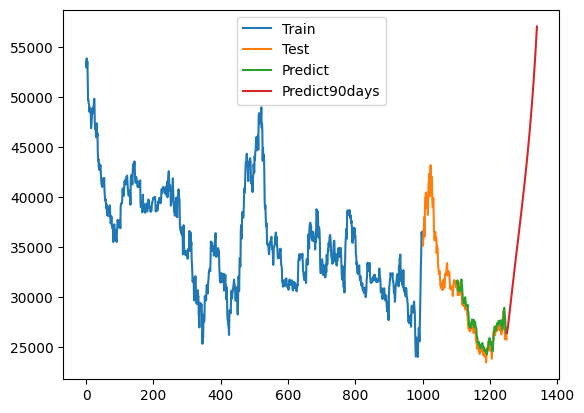

In [24]:
# 14.Vẽ hình 90 ngay 

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index_90,scaler.inverse_transform(lst_output_90))
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()

VIB


In [25]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/VIB.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [26]:
df1=df.reset_index()['Price']

In [27]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [28]:
#. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [29]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [30]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [31]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [32]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.2270
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0199
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0115
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0086
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0049
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0010
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.4359e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.6697e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.4087e-04
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.3053e-04
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.2448e-04
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.6788e-04
Epoch 15/100
14/14 ━━━━━━━━━━━━━━

In [34]:
# . Dự báo dữ liệu test

y_pred=model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [35]:
# . Chuẩn hóa dữ liệu y_pred
y_pred=scaler.inverse_transform(y_pred)

In [36]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [37]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 363.66638085798115
Testing MAPE: 1.562665762266761
Testing Mae: 164.48575076541385


In [38]:
# Dự báo 30 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.18775646]
101
1 day input [0.09370148 0.09370148 0.09677616 0.09677616 0.08907425 0.09214892
 0.08907425 0.07988067 0.06913452 0.06758197 0.06758197 0.07065664
 0.07065664 0.06554233 0.06106731 0.05363938 0.05363938 0.05214771
 0.05065603 0.05363938 0.05363938 0.05513105 0.05659229 0.05659229
 0.05363938 0.05363938 0.05659229 0.05659229 0.05214771 0.05214771
 0.05513105 0.05808396 0.06255898 0.06106731 0.067034   0.06602941
 0.06602941 0.0674602  0.0674602  0.0674602  0.06892143 0.07035222
 0.07178301 0.07324424 0.07467503 0.07467503 0.07324424 0.07610582
 0.07610582 0.07610582 0.07467503 0.17930531 0.17729611 0.17324728
 0.17525648 0.17930531 0.17930531 0.1813145  0.18536333 0.19139091
 0.19139091 0.18938172 0.18737252 0.19139091 0.19139091 0.19139091
 0.19543974 0.19543974 0.19543974 0.19744893 0.19744893 0.19948857
 0.20149776 0.19948857 0.19948857 0.19543974 0.19543974 0.19543974
 0.19139091 0.19139091 0.18536333 0.1813145  0.18332369 0.19543974
 0.18938172 0.19744893 0.20149776

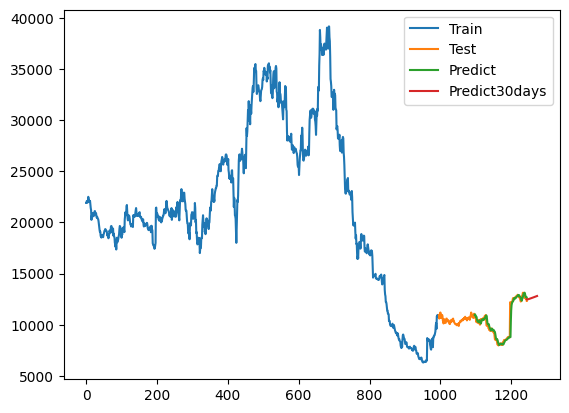

In [39]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [40]:
# Dự báo 60 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1

[0.18775646]
101
1 day input [0.09370148 0.09370148 0.09677616 0.09677616 0.08907425 0.09214892
 0.08907425 0.07988067 0.06913452 0.06758197 0.06758197 0.07065664
 0.07065664 0.06554233 0.06106731 0.05363938 0.05363938 0.05214771
 0.05065603 0.05363938 0.05363938 0.05513105 0.05659229 0.05659229
 0.05363938 0.05363938 0.05659229 0.05659229 0.05214771 0.05214771
 0.05513105 0.05808396 0.06255898 0.06106731 0.067034   0.06602941
 0.06602941 0.0674602  0.0674602  0.0674602  0.06892143 0.07035222
 0.07178301 0.07324424 0.07467503 0.07467503 0.07324424 0.07610582
 0.07610582 0.07610582 0.07467503 0.17930531 0.17729611 0.17324728
 0.17525648 0.17930531 0.17930531 0.1813145  0.18536333 0.19139091
 0.19139091 0.18938172 0.18737252 0.19139091 0.19139091 0.19139091
 0.19543974 0.19543974 0.19543974 0.19744893 0.19744893 0.19948857
 0.20149776 0.19948857 0.19948857 0.19543974 0.19543974 0.19543974
 0.19139091 0.19139091 0.18536333 0.1813145  0.18332369 0.19543974
 0.18938172 0.19744893 0.20149776

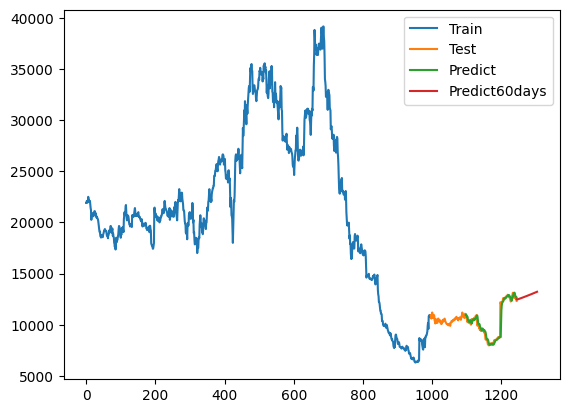

In [41]:
#Vẽ hình du doan 60 ngay

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index_60,scaler.inverse_transform(lst_output_60))

plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

In [42]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1

[0.18775646]
101
1 day input [0.09370148 0.09370148 0.09677616 0.09677616 0.08907425 0.09214892
 0.08907425 0.07988067 0.06913452 0.06758197 0.06758197 0.07065664
 0.07065664 0.06554233 0.06106731 0.05363938 0.05363938 0.05214771
 0.05065603 0.05363938 0.05363938 0.05513105 0.05659229 0.05659229
 0.05363938 0.05363938 0.05659229 0.05659229 0.05214771 0.05214771
 0.05513105 0.05808396 0.06255898 0.06106731 0.067034   0.06602941
 0.06602941 0.0674602  0.0674602  0.0674602  0.06892143 0.07035222
 0.07178301 0.07324424 0.07467503 0.07467503 0.07324424 0.07610582
 0.07610582 0.07610582 0.07467503 0.17930531 0.17729611 0.17324728
 0.17525648 0.17930531 0.17930531 0.1813145  0.18536333 0.19139091
 0.19139091 0.18938172 0.18737252 0.19139091 0.19139091 0.19139091
 0.19543974 0.19543974 0.19543974 0.19744893 0.19744893 0.19948857
 0.20149776 0.19948857 0.19948857 0.19543974 0.19543974 0.19543974
 0.19139091 0.19139091 0.18536333 0.1813145  0.18332369 0.19543974
 0.18938172 0.19744893 0.20149776

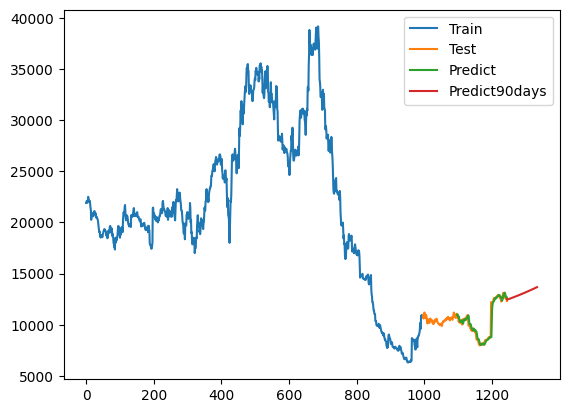

In [43]:
# 14.Vẽ hình 90 ngay 

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index_90,scaler.inverse_transform(lst_output_90))
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()

STB


In [44]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/STB.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [45]:
df1=df.reset_index()['Price']

In [46]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [47]:
#. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [48]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [49]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [50]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [51]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1153
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0164
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0061
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0027
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0012
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.7590e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.0247e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.2909e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.4039e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.0723e-04
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.6921e-04
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.2367e-04
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.4732e-04
Epoch 15/100
15/15 ━━━━━━

In [53]:
# . Dự báo dữ liệu test

y_pred=model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [54]:
# . Chuẩn hóa dữ liệu y_pred

y_pred=scaler.inverse_transform(y_pred)

In [55]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [56]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 145.65188011030483
Testing MAPE: 0.9897346866755738
Testing Mae: 112.20075241191275


In [57]:
# Dự báo 30 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.19238509]
101
1 day input [0.14185639 0.14711033 0.14711033 0.15411559 0.14886165 0.14886165
 0.14360771 0.14185639 0.14360771 0.14711033 0.14535902 0.14185639
 0.14360771 0.14360771 0.14535902 0.14185639 0.14535902 0.14886165
 0.14185639 0.14010508 0.14711033 0.15236427 0.15411559 0.14535902
 0.14711033 0.14010508 0.13660245 0.14535902 0.15236427 0.15061296
 0.15236427 0.15411559 0.15761821 0.1558669  0.14886165 0.15236427
 0.15061296 0.15061296 0.1558669  0.15761821 0.1558669  0.15761821
 0.15761821 0.15761821 0.16462347 0.16637478 0.16637478 0.16287215
 0.16287215 0.16462347 0.16637478 0.16112084 0.16287215 0.16462347
 0.16112084 0.16987741 0.16812609 0.16637478 0.17688266 0.16112084
 0.16287215 0.15936953 0.16637478 0.16637478 0.14886165 0.1558669
 0.1558669  0.16112084 0.16637478 0.16812609 0.16637478 0.16812609
 0.17338004 0.17338004 0.17338004 0.17513135 0.17338004 0.17162872
 0.17863398 0.17162872 0.16987741 0.17688266 0.17513135 0.17338004
 0.18388792 0.1821366  0.19264448 

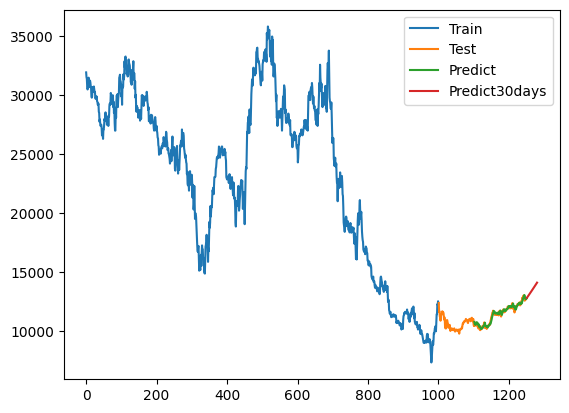

In [58]:
# 14.Vẽ hình du doan 30 ngay

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [59]:
# Dự báo 60 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1

[0.19238509]
101
1 day input [0.14185639 0.14711033 0.14711033 0.15411559 0.14886165 0.14886165
 0.14360771 0.14185639 0.14360771 0.14711033 0.14535902 0.14185639
 0.14360771 0.14360771 0.14535902 0.14185639 0.14535902 0.14886165
 0.14185639 0.14010508 0.14711033 0.15236427 0.15411559 0.14535902
 0.14711033 0.14010508 0.13660245 0.14535902 0.15236427 0.15061296
 0.15236427 0.15411559 0.15761821 0.1558669  0.14886165 0.15236427
 0.15061296 0.15061296 0.1558669  0.15761821 0.1558669  0.15761821
 0.15761821 0.15761821 0.16462347 0.16637478 0.16637478 0.16287215
 0.16287215 0.16462347 0.16637478 0.16112084 0.16287215 0.16462347
 0.16112084 0.16987741 0.16812609 0.16637478 0.17688266 0.16112084
 0.16287215 0.15936953 0.16637478 0.16637478 0.14886165 0.1558669
 0.1558669  0.16112084 0.16637478 0.16812609 0.16637478 0.16812609
 0.17338004 0.17338004 0.17338004 0.17513135 0.17338004 0.17162872
 0.17863398 0.17162872 0.16987741 0.17688266 0.17513135 0.17338004
 0.18388792 0.1821366  0.19264448 

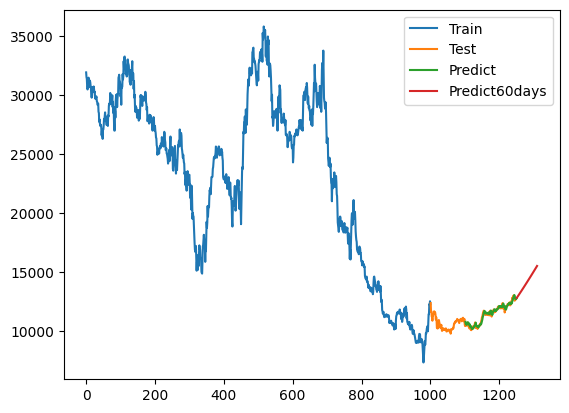

In [60]:
#Vẽ hình du doan 60 ngay

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index_60,scaler.inverse_transform(lst_output_60))

plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

In [61]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1

[0.19238509]
101
1 day input [0.14185639 0.14711033 0.14711033 0.15411559 0.14886165 0.14886165
 0.14360771 0.14185639 0.14360771 0.14711033 0.14535902 0.14185639
 0.14360771 0.14360771 0.14535902 0.14185639 0.14535902 0.14886165
 0.14185639 0.14010508 0.14711033 0.15236427 0.15411559 0.14535902
 0.14711033 0.14010508 0.13660245 0.14535902 0.15236427 0.15061296
 0.15236427 0.15411559 0.15761821 0.1558669  0.14886165 0.15236427
 0.15061296 0.15061296 0.1558669  0.15761821 0.1558669  0.15761821
 0.15761821 0.15761821 0.16462347 0.16637478 0.16637478 0.16287215
 0.16287215 0.16462347 0.16637478 0.16112084 0.16287215 0.16462347
 0.16112084 0.16987741 0.16812609 0.16637478 0.17688266 0.16112084
 0.16287215 0.15936953 0.16637478 0.16637478 0.14886165 0.1558669
 0.1558669  0.16112084 0.16637478 0.16812609 0.16637478 0.16812609
 0.17338004 0.17338004 0.17338004 0.17513135 0.17338004 0.17162872
 0.17863398 0.17162872 0.16987741 0.17688266 0.17513135 0.17338004
 0.18388792 0.1821366  0.19264448 

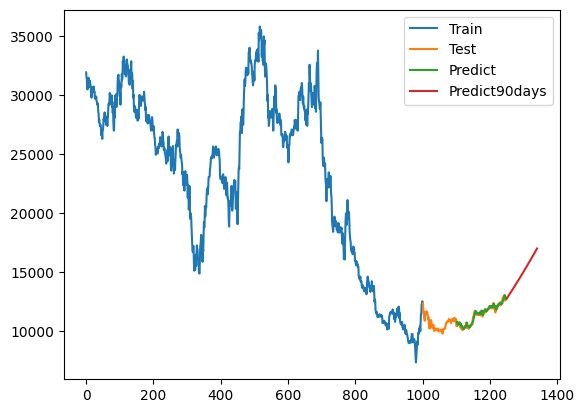

In [62]:
# 14.Vẽ hình 90 ngay 

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index_90,scaler.inverse_transform(lst_output_90))
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()